In [6]:
import numpy as np
import tensorflow as tf
import keras
from keras import models
import keras.layers as kl
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling1D
from keras.metrics import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import History
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc 

In [7]:
def one_hot_encoding(dna_sequence):
    """
    Converts a DNA sequence to one-hot-encoding
    :param dna_sequence: nucleotide sequence
    :type dna_sequence: str
    :return: lst of encoding for each nucleotide in the original DNA string
    :rtype: lst of lst of ints
    :author: Sydney Ballard
    """
    # Define a dictionary for 1-hot encoding
    nucleotide_dict = {'A': [1, 0, 0, 0], 
                       'C': [0, 1, 0, 0], 
                       'G': [0, 0, 1, 0], 
                       'T': [0, 0, 0, 1]}
    
    # Convert the DNA sequence to 1-hot encoding
    one_hot_encoding = [nucleotide_dict[base] for base in dna_sequence]  

    # Return list of one hot encodings
    return one_hot_encoding


def parse_data(file_name):
    """
    Converts a FASTA file to a dictionary.
    :param file_name: The name of the input FASTA file.
    :type file_name: str
    :return: A dictionary of each key with a list of two elements: 
        the key is the original nucleotide sequence
        the first element of the list contains the one-hot-encoding of the sequence (reference one_hot_encoding function above)
        and the second element of the list contains the corresponding class names/enhancer identifier (0 or 1)
    :rtype: dict
    :author: Sydney Ballard
    :acknowledgements: Adapted from parse_fasta_file, which Kush Gulati wrote for previous assignments
    """
    # Initialize dictionary 
    # {sequence: [one hot encoding of sequence, enhancer identifier]}
    sequence_data = {} # dict will hold 0/1 for class and sequence

    sequences = []
    class_names = []
    with open(file_name) as file:
        sequence = ""
        class_name = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                class_name = line.split("/")[-1][6:]
                class_names.append(class_name)
                if sequence:
                    sequences.append(sequence)
                    sequence = ""
            else:
                sequence += line
        sequences.append(sequence)
    
    for idx in range(len(sequences)):
        seq = sequences[idx]
        class_encoding = class_names[idx]

        # 0th element = encoding, 1st element = enhancer identifier
        sequence_data[seq] = [one_hot_encoding(seq), class_encoding]

    # print(list(sequence_data.values())[0][1])    
    return sequence_data

In [8]:
def transform_data(data_dict):
    """
    Transform the data dictionary read by parse_data function to numpy arrays.
    :param data_dict: The name of the input data dictionary.
    :type data_dict: dictionary
    :return: A tuple of two elements: the numpy array of input data X and target data Y
    :rtype: tuple
    :author: Qi Gao
    """
    count = 0
    X = []
    Y = []
    for i in data_dict.values():
        X.append(i[0])
        Y.append(float(i[1]))
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    Y = np.array(Y)
    return X, Y

In [9]:
sim1_data_train = parse_data("sim1/train.fasta")
sim1_data_valid = parse_data("sim1/validation.fasta")
sim1_data_test = parse_data("sim1/test.fasta")
X_train, Y_train = transform_data(sim1_data_train)
X_valid, Y_valid = transform_data(sim1_data_valid)
X_test, Y_test = transform_data(sim1_data_test)

In [10]:
''' This model is designed by Qi Gao.'''

model = Sequential()

model.add(Convolution2D(32, (6, 4), activation='relu', input_shape=(249, 4, 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, verbose=1, validation_data=(X_valid, Y_valid),batch_size=128, epochs=100, 
          callbacks=[EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True), History()])

2023-04-11 21:45:57.923504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
157/157 [==============================] - 6s 38ms/step - loss: 0.6958 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/100
157/157 [==============================] - 5s 31ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
157/157 [==============================] - 4s 28ms/step - loss: 0.6928 - accuracy: 0.5106 - val_loss: 0.6910 - val_accuracy: 0.6896
Epoch 4/100
157/157 [==============================] - 5s 33ms/step - loss: 0.5231 - accuracy: 0.7625 - val_loss: 0.0855 - val_accuracy: 0.9837
Epoch 5/100
157/157 [==============================] - 5s 33ms/step - loss: 0.0621 - accuracy: 0.9865 - val_loss: 0.0166 - val_accuracy: 0.9959
Epoch 6/100
157/157 [==============================] - 5s 34ms/step - loss: 0.0204 - accuracy: 0.9959 - val_loss: 0.0212 - val_accuracy: 0.9942
Epoch 7/100
157/157 [==============================] - 5s 34ms/step - loss: 0.0119 - accuracy: 0.9972 - val_loss: 0.0128 - val_accuracy:

In [11]:
'''Evaluate the performance on test dataset.'''
pred = model.predict(X_test, batch_size=128)
np.sum(pred.argmax(axis = 1) == Y_test) / len(Y_test)

157/157 [==============================] - 3s 12ms/step


0.99715

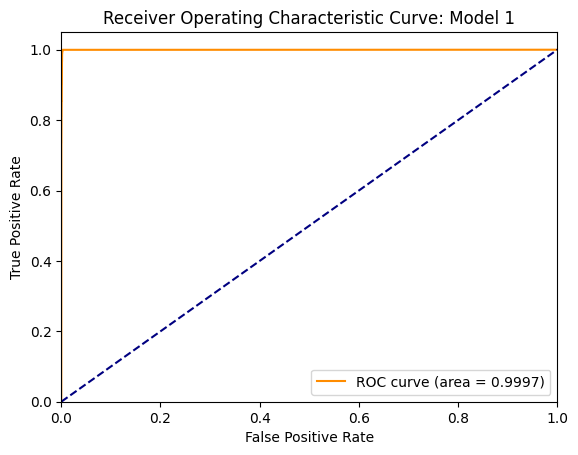

AUC: 0.9997


In [12]:
fpr, tpr, thresholds = roc_curve(Y_test, pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: Model 1')
plt.legend(loc="lower right")
plt.show()
print("AUC: %0.4f" % roc_auc)

In [7]:
''' This model is designed by Qi Gao. (double check)'''
model = Sequential()

model.add(Convolution2D(32, (6, 4), activation='relu', input_shape=(249, 4, 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, verbose=1, validation_data=(X_valid, Y_valid),batch_size=128, epochs=100, 
          callbacks=[EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True), History()])

Epoch 1/100
157/157 [==============================] - 5s 27ms/step - loss: 0.6957 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 2/100
157/157 [==============================] - 4s 23ms/step - loss: 0.6935 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5041
Epoch 3/100
157/157 [==============================] - 4s 25ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6930 - val_accuracy: 0.5297
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6844 - val_accuracy: 0.5121
Epoch 5/100
157/157 [==============================] - 4s 25ms/step - loss: 0.4437 - accuracy: 0.7929 - val_loss: 0.0613 - val_accuracy: 0.9801
Epoch 6/100
157/157 [==============================] - 4s 24ms/step - loss: 0.0453 - accuracy: 0.9887 - val_loss: 0.0133 - val_accuracy: 0.9967
Epoch 7/100
157/157 [==============================] - 4s 24ms/step - loss: 0.0172 - accuracy: 0.9967 - val_loss: 0.0208 - val_accuracy:

In [8]:
'''Evaluate the performance on test dataset (double check).'''
pred = model.predict(X_test, batch_size=128)
np.sum(pred.argmax(axis = 1) == Y_test) / len(Y_test)

157/157 [==============================] - 1s 5ms/step


0.99705